# Qiita

* 対象データ
  * 期間: 2017/12/15〜2018/12/3
  * データ件数: 87,990記事
  * 内容: 記事データ（item）※本文（body）は除く
  * 取得方法: API経由: [Qiitaの記事データをQiita API, Scrapyで収集](https://qiita.com/nkmk/items/fbac13cd05b80334eb2b)
  
## バズる記事とは？

ざっくり

* いいね数（likes_count）が多い記事

参考記事（[お前らの記事のタイトルは間違っている〜爆速で誰でもできるQiitaでバズらせる6個の必殺技まとめ]）によると `タイトルに数字を入れてボリューム感を出す` という手法が良いらしい。

では数字を何個入れるとよいのか調べてみる。

  
## 参考資料

* Qiita: [お前らの記事のタイトルは間違っている〜爆速で誰でもできるQiitaでバズらせる6個の必殺技まとめ](https://qiita.com/SugarShootingStar/items/bba0fab1e55936e7234a)
* Qiita: [Qiitaの記事データをQiita API, Scrapyで収集](https://qiita.com/nkmk/items/fbac13cd05b80334eb2b)
* blog: [Bayesian Poisson A/B Testing in PYMC3 on Python](http://barnesanalytics.com/bayesian-poisson-ab-testing-in-pymc3-on-python)

In [1]:
import numpy as np
import pandas as pd

from pandas_summary import DataFrameSummary

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style="ticks")

import pymc3 as pm

import collections
import string

Qiita APIから取得済みデータを読み込む

In [2]:
df = pd.read_csv('input/summary.csv')

データの形

* カラム数: 10
* レコード数: 87990

In [3]:
print("カラム数: {}".format(df.shape[1]))
print("レコード数: {}".format(df.shape[0]))

カラム数: 10
レコード数: 87990


カラム一覧

In [4]:
for c in df.columns:
    print(c)

title
id
created_at
updated_at
likes_count
comments_count
tags_str
user_id
user_permanent_id
url


In [5]:
df.head(3).T

,0,1,2
title,DynamoDB ローカルでチュートリアル,C++で初めてのゲーム開発する時に、気をつけて欲しいこと,LSTMの簡易まとめ
id,022f5c5b4e45f42727e9,1b7ab644e7de7709b073,636ec5e15df4e57f78a0
created_at,2017-12-31T08:54:37+09:00,2017-12-31T08:39:29+09:00,2017-12-31T08:32:55+09:00
updated_at,2017-12-31T08:54:37+09:00,2017-12-31T14:21:16+09:00,2018-01-04T11:16:21+09:00
likes_count,1,35,2
comments_count,0,0,0
tags_str,"AWS,チュートリアル,DynamoDB",C++,"機械学習,深層学習,LSTM,TensorFlow"
user_id,h2m_kinoko,4_mio_11,matsui-k20xx
user_permanent_id,119864,36899,214997
url,https://qiita.com/h2m_kinoko/items/022f5c5b4e4...,https://qiita.com/4_mio_11/items/1b7ab644e7de7...,https://qiita.com/matsui-k20xx/items/636ec5e15...


# EDA

要約統計量

In [6]:
DataFrameSummary(df).summary()

,title,id,created_at,updated_at,likes_count,comments_count,tags_str,user_id,user_permanent_id,url
count,NaN,NaN,NaN,NaN,87990,87990,NaN,NaN,87990,NaN
mean,NaN,NaN,NaN,NaN,8.14695,0.319536,NaN,NaN,147979,NaN
std,NaN,NaN,NaN,NaN,58.1444,1.69247,NaN,NaN,88418.7,NaN
min,NaN,NaN,NaN,NaN,0,0,NaN,NaN,29,NaN
25%,NaN,NaN,NaN,NaN,0,0,NaN,NaN,65978,NaN
50%,NaN,NaN,NaN,NaN,1,0,NaN,NaN,148882,NaN
75%,NaN,NaN,NaN,NaN,4,0,NaN,NaN,227518,NaN
max,NaN,NaN,NaN,NaN,3583,104,NaN,NaN,322336,NaN
counts,87990,87990,87990,87990,87990,87990,87990,87990,87990,87990
uniques,87815,87990,87815,87825,603,54,54919,21091,21091,87990


## いいね数

いいね数の分布

(array([8.7635e+04, 2.2500e+02, 6.4000e+01, 3.8000e+01, 1.6000e+01,
        6.0000e+00, 4.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   0. ,  358.3,  716.6, 1074.9, 1433.2, 1791.5, 2149.8, 2508.1,
        2866.4, 3224.7, 3583. ]),
 <a list of 10 Patch objects>)

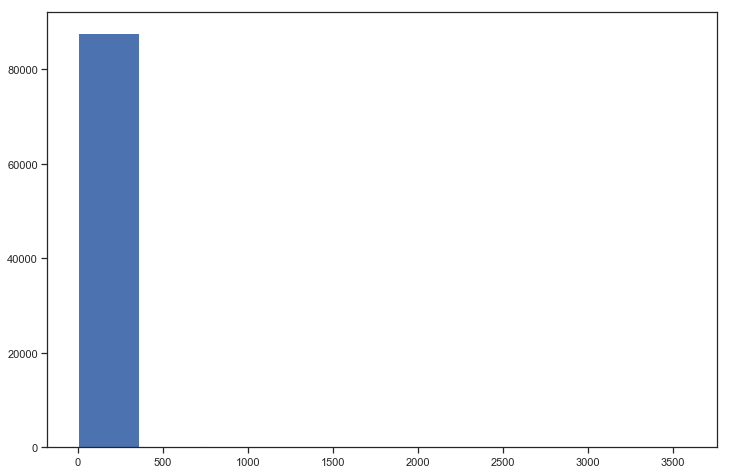

In [7]:
plt.figure(figsize=(12, 8))
plt.hist(df['likes_count'])

いいねが0の割合

* いいね0の記事は全体の約32%

In [8]:
print("{:.2f}%".format(len(df[df['likes_count']==0]) / len(df) * 100))

31.65%


いいね数の分布がエグいの対数変換してみる

* 対数変換すると少しましになる

(array([4.6195e+04, 2.2701e+04, 1.1175e+04, 4.9110e+03, 1.5020e+03,
        6.8100e+02, 4.0800e+02, 2.8200e+02, 1.1500e+02, 2.0000e+01]),
 array([0.        , 0.81842348, 1.63684695, 2.45527043, 3.27369391,
        4.09211739, 4.91054086, 5.72896434, 6.54738782, 7.3658113 ,
        8.18423477]),
 <a list of 10 Patch objects>)

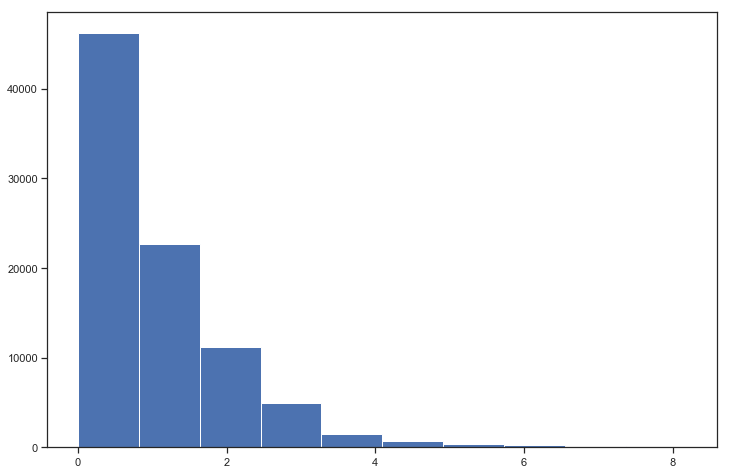

In [9]:
plt.figure(figsize=(12, 8))
plt.hist(np.log(df['likes_count'].values+1))

## いいね数の詳細

In [10]:
df_with_likes = df[df['likes_count']>0]
print("count: {}".format(len(df_with_likes)))

count: 60137


いいね数が多い記事のTop20

* いいね数が多い記事は平均してコメントも多い傾向にある

In [11]:
df_with_likes.sort_values(by='likes_count', ascending=False)[[
    "title",
    "tags_str",
    "comments_count",
    "likes_count",
    "url"
]].head(20)

,title,tags_str,comments_count,likes_count,url
1054,イマドキのJavaScriptの書き方2018,JavaScript,45,3583,https://qiita.com/shibukawa/items/19ab5c381bbb...
33967,開設後３週間で収益１０万円を得た個人開発サイトでやったことの全部を公開する,"Ruby,JavaScript,Heroku,AWS,個人開発",37,2686,https://qiita.com/jabba/items/1a49e860a09a613b...
37148,2018年の最先端バックエンドエンジニアに必要なスキルについて考えてみました。,"AWS,gcp,キャリア",15,2487,https://qiita.com/poly_soft/items/fb649573c19b...
69409,[2018] 個人でも使える！おすすめAPI一覧,"Python,Instagram,GoogleCloudPlatform",15,2439,https://qiita.com/mikan3rd/items/ba4737023f08b...
33628,コーディングをするときに鼻血がでるほど便利なwebツールリスト(随時更新予定),"正規表現,Web,tool,coding,naming",18,2404,https://qiita.com/isuke/items/7fcc5eb0b985005b...
65115,Chrome拡張の高速な英語辞書ツールをつくりました(Mouse Dictionary),"JavaScript,Chrome,chrome-extension,English",31,2349,https://qiita.com/wtetsu/items/c43232c6c44918e...
73204,エンジニアは全員技術記事を書くことを習慣化した方がいいぞ,"Qiita,翻訳,アウトプット,新人プログラマ応援",44,2090,https://qiita.com/HiromuMasuda0228/items/a71de...
68548,なぜ我々はいまだに文字列でコメントを書いているのか,"Emacs,SublimeText3,コメント,Visual,VSCode",23,2062,https://qiita.com/tkrkt/items/2fc9a9a59ce679aa...
70338,もっと気軽にアウトプットできる技術ブログサービス「Qrunch（クランチ）」をリリースした【...,"Ruby,Markdown,RubyOnRails,Webサービス,個人開発",34,1952,https://qiita.com/c0domisu/items/95a561d163d26...
10263,【今日からできる】コミットメッセージに 「プレフィックス」 をつけるだけで、開発効率が上がった話,"Git,GitHub,devops,チーム,新人プログラマ応援",33,1947,https://qiita.com/numanomanu/items/45dd285b286...


# タイトルに含まれる数字の数を数える

タイトルの長さを数える

In [12]:
title_lengths = [len(x) for x in df["title"].values]

ちなみに最大文字数のタイトルは239文字

In [13]:
print(max(df["title"], key=len))
print(len(max(df["title"], key=len)))

YYPHP#54「PhpStormの法人ライセンスは1台にしか入れられない？、Laravelでブログを作るには？、Chromeのみ対応のシステムをIE11対応させたいが…、みんながDockerをどんなふうに使っているのか開発のしかたなどを聞きたい、PHPはフランス語に弱い？、前前人者が作ったシステムが良くわからない、型とオブジェクト指向がマイブームで再燃しているのはなぜか？、PhpStormのEAPでコレクション型のジェネリクス表記ができるようになったよ、技術書典５の案内」
239


ひらがな・カタカナ

In [14]:
hiraganas = [chr(x) for x in range(ord('あ'), ord('ん')+1)]
katakanas = [chr(x) for x in range(ord('ア'), ord('ン')+1)]
katakanas.append('ー')

In [15]:
def count_hiraganas(s):
    c = collections.Counter(s)
    return {k[0]: k[1] for k in c.items() if k[0] in hiraganas}

In [16]:
def count_katakanas(s):
    c = collections.Counter(s)
    return {k[0]: k[1] for k in c.items() if k[0] in katakanas}

In [17]:
hiragana_lengths = [sum(count_hiraganas(x).values()) for x in df["title"].values]
katakana_lengths = [sum(count_katakanas(x).values()) for x in df["title"].values]

小文字・大文字アルファベットをカウント

In [18]:
def count_alphabets(s):
    c = collections.Counter(s)
    return {k[0]: k[1] for k in c.items() if k[0] in string.ascii_letters}

In [19]:
aflphabet_lengths = [sum(count_alphabets(x).values()) for x in df["title"].values]

半角数字と全角数字をカウント

In [20]:
def count_digits(s):
    c = collections.Counter(s)
    return {k[0]: k[1] for k in c.items() if (k[0] in '０１２３４５６７８９') or (k[0] in string.digits)}

数字の文字数

In [21]:
digit_lengths = [sum(count_digits(x).values()) for x in df["title"].values]

In [22]:
digit_lengths[:10]

[0, 0, 0, 2, 0, 0, 0, 0, 1, 1]

In [23]:
df["title"].values[:10]

array(['DynamoDB ローカルでチュートリアル', 'C++で初めてのゲーム開発する時に、気をつけて欲しいこと',
       'LSTMの簡易まとめ', 'Mastodonで始めるPythonプログラミング！腕試しテスト50本ノック（初級編）',
       'create-react-appでReactの開発環境を構築する', 'Hyperappを読む',
       'matplotlib の legend(凡例) の 位置を調整する legend bbox_to_anchor loc',
       'ノートンいれたらMacが再起動から復帰しなくなった。(復旧済み)', 'Cloud9上でJupyterを動かせる環境を作ってみた',
       'AWSのEC2を使ってJupyterをブラウザから使えるようにする方法'], dtype=object)

## 前処理

In [24]:
df.shape, len(title_lengths), len(digit_lengths), len(aflphabet_lengths), len(hiragana_lengths), len(katakana_lengths)

((87990, 10), 87990, 87990, 87990, 87990, 87990)

In [25]:
df["title_length"] = title_lengths
df["aflphabet_count"] = aflphabet_lengths
df["hiragana_count"] = hiragana_lengths
df["katakana_count"] = katakana_lengths

In [26]:
df["digit_count"] = digit_lengths
df["has_digit"] = (df["digit_count"] > 0) * 1

In [27]:
print("{:.2f}%".format(len(df[df["has_digit"] == 1]) / len(df)* 100))

26.64%


それ以外

In [29]:
df["other_count"] = df["title_length"] - (df["digit_count"] + df["aflphabet_count"] + df["hiragana_count"] + df["katakana_count"])

数字使いすぎているタイトルは削除

In [585]:
# df_new = df[df["digit_count"] < 27] # 数字が27未満のレコードのみ抽出

In [550]:
# digit_unique = df_new["digit_count"].unique()
# digit_unique.sort()
# digit_unique

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26])

In [53]:
df.sort_values(by='likes_count', ascending=True)[[
    "title",
    "title_length",    
    "likes_count",
    "comments_count",
    "has_digit",
    "digit_count",
    "aflphabet_count",
    "hiragana_count",
    "katakana_count",
    "other_count",
    "tags_str",
]].head(50)

,title,title_length,likes_count,comments_count,has_digit,digit_count,aflphabet_count,hiragana_count,katakana_count,other_count,tags_str
87989,非同期通知が来ない事を確認するテストを行う,21,0,0,0,0,0,8,3,10,"iOS,Notification,ユニットテスト,テスト駆動開発"
23198,hello world!,12,0,0,0,0,10,0,0,2,HelloWorld
59811,【Javascript/Node.js】ある配列が別の配列の部分集合であることを判定する,44,0,0,0,0,16,13,0,15,"JavaScript,Node.js"
59815,インメモリデータベース VoltDBの最新バージョン（v8.3.1）をインストールする（クラ...,51,0,0,1,3,7,4,26,11,"データベース,VoltDB"
59822,Scala Futureのawait/readyをもっと楽にする方法,34,0,0,0,0,21,8,0,5,Scala
59826,Ubuntu18.04にrubyを入れる,20,0,0,1,4,10,4,0,2,"Ruby,Ubuntu"
59827,Mac と Amazon Linux WorkSpaces の組み合わせでアンダーバーを入力する,48,0,0,0,0,24,9,6,9,"Mac,workspaces,キーボード,xkb,AmazonLinux2"
59828,githubに対してローカルコミットした内容が反映されなくなったとき,34,0,0,0,0,6,15,8,5,GitHub
23186,FirefoxでIndexedDBが利用できないときの対処法,30,0,0,0,0,16,9,0,5,"JavaScript,firefox,indexedDB"
59833,RT1310AでPCIサポートしてみた,19,0,0,1,4,6,5,4,0,"FreeBSD,ARM,PCI"


In [32]:
df.sort_values(by='likes_count', ascending=False)[[
    "title",
    "title_length",    
    "likes_count",
    "comments_count",
    "has_digit",
    "digit_count",
    "aflphabet_count",
    "hiragana_count",
    "katakana_count",
    "other_count",
    "tags_str",
]].head(50)

,title,title_length,likes_count,comments_count,has_digit,digit_count,aflphabet_count,hiragana_count,katakana_count,other_count,tags_str
1054,イマドキのJavaScriptの書き方2018,23,3583,45,1,4,10,3,4,2,JavaScript
33967,開設後３週間で収益１０万円を得た個人開発サイトでやったことの全部を公開する,37,2686,37,1,3,0,13,3,18,"Ruby,JavaScript,Heroku,AWS,個人開発"
37148,2018年の最先端バックエンドエンジニアに必要なスキルについて考えてみました。,39,2487,15,1,4,0,13,14,8,"AWS,gcp,キャリア"
69409,[2018] 個人でも使える！おすすめAPI一覧,24,2439,15,1,4,3,8,0,9,"Python,Instagram,GoogleCloudPlatform"
33628,コーディングをするときに鼻血がでるほど便利なwebツールリスト(随時更新予定),39,2404,18,0,0,3,12,12,12,"正規表現,Web,tool,coding,naming"
65115,Chrome拡張の高速な英語辞書ツールをつくりました(Mouse Dictionary),44,2349,31,0,0,21,9,3,11,"JavaScript,Chrome,chrome-extension,English"
73204,エンジニアは全員技術記事を書くことを習慣化した方がいいぞ,28,2090,44,0,0,0,12,5,11,"Qiita,翻訳,アウトプット,新人プログラマ応援"
68548,なぜ我々はいまだに文字列でコメントを書いているのか,25,2062,23,0,0,0,15,4,6,"Emacs,SublimeText3,コメント,Visual,VSCode"
70338,もっと気軽にアウトプットできる技術ブログサービス「Qrunch（クランチ）」をリリースした【...,51,1952,34,0,0,6,10,21,14,"Ruby,Markdown,RubyOnRails,Webサービス,個人開発"
10263,【今日からできる】コミットメッセージに 「プレフィックス」 をつけるだけで、開発効率が上がった話,48,1947,33,0,0,0,17,16,15,"Git,GitHub,devops,チーム,新人プログラマ応援"


# 可視化

In [33]:
df_few_digit = df[df["digit_count"] < 5]

(array([8.4361e+04, 2.1600e+02, 6.3000e+01, 3.7000e+01, 1.6000e+01,
        6.0000e+00, 4.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   0. ,  358.3,  716.6, 1074.9, 1433.2, 1791.5, 2149.8, 2508.1,
        2866.4, 3224.7, 3583. ]),
 <a list of 10 Patch objects>)

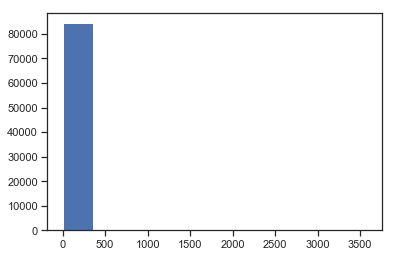

In [34]:
plt.hist(df_few_digit["likes_count"])

(array([7.5481e+04, 2.9650e+03, 4.3190e+03, 1.0370e+03, 5.5100e+02,
        2.0700e+02, 8.5000e+01, 4.0000e+01, 1.5000e+01, 5.0000e+00]),
 array([0.        , 0.46539604, 0.93079207, 1.39618811, 1.86158414,
        2.32698018, 2.79237621, 3.25777225, 3.72316828, 4.18856432,
        4.65396035]),
 <a list of 10 Patch objects>)

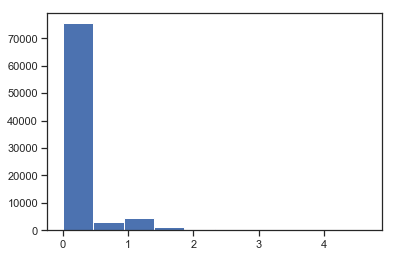

In [35]:
plt.hist(np.log(df_few_digit["comments_count"]+1))

In [36]:
# df_few_digit["log_title_length"] = np.log(df_few_digit["title_length"].values+1)
# df_few_digit["log_likes_count"] = np.log(df_few_digit["likes_count"].values+1)
# df_few_digit["log_comments_count"] = np.log(df_few_digit["comments_count"].values+1)
# df_few_digit["log_aflphabet_count"] = np.log(df_few_digit["aflphabet_count"].values+1)
# df_few_digit["log_hiragana_count"] = np.log(df_few_digit["hiragana_count"].values+1)
# df_few_digit["log_katakana_count"] = np.log(df_few_digit["katakana_count"].values+1)

In [37]:
# sns.pairplot(df_few_digit[[ 
#     "log_likes_count",
#     "log_comments_count",
#     "digit_count",
#     "aflphabet_count",
#     "hiragana_count",
#     "katakana_count",
# ]])

In [42]:
no_digit, has_digit = df_few_digit["has_digit"].value_counts()
no_digit, has_digit

(64551, 20154)

In [41]:
no_digit

64551

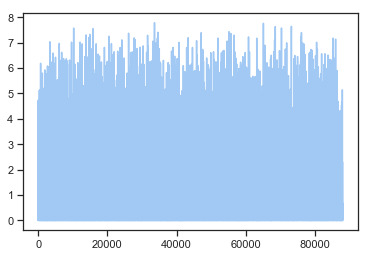

In [49]:
plt.plot(np.log(df_few_digit[df_few_digit["has_digit"] == 0]["likes_count"]+1))

(array([4.6195e+04, 2.2701e+04, 1.1175e+04, 4.9110e+03, 1.5020e+03,
        6.8100e+02, 4.0800e+02, 2.8200e+02, 1.1500e+02, 2.0000e+01]),
 array([0.        , 0.81842348, 1.63684695, 2.45527043, 3.27369391,
        4.09211739, 4.91054086, 5.72896434, 6.54738782, 7.3658113 ,
        8.18423477]),
 <a list of 10 Patch objects>)

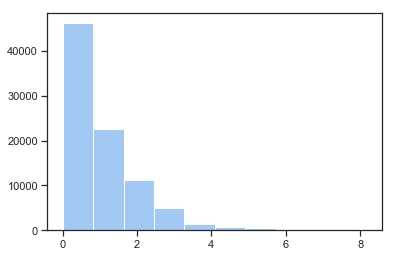

In [52]:
plt.hist(np.log(df["likes_count"]+1))

(array([4.3971e+04, 2.2059e+04, 1.0925e+04, 4.8070e+03, 1.4720e+03,
        6.6500e+02, 4.0100e+02, 2.7200e+02, 1.1300e+02, 2.0000e+01]),
 array([0.        , 0.81842348, 1.63684695, 2.45527043, 3.27369391,
        4.09211739, 4.91054086, 5.72896434, 6.54738782, 7.3658113 ,
        8.18423477]),
 <a list of 10 Patch objects>)

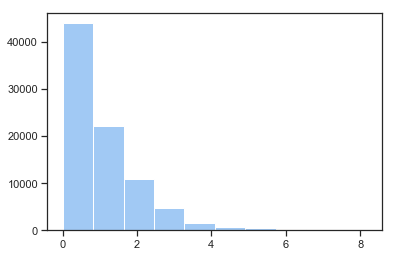

In [51]:
plt.hist(np.log(df_few_digit["likes_count"]+1))

(array([33324., 13141., 11538.,  3908.,  1358.,   557.,   339.,   233.,
          113.,    40.]),
 array([0.        , 0.77853052, 1.55706104, 2.33559155, 3.11412207,
        3.89265259, 4.67118311, 5.44971363, 6.22824415, 7.00677466,
        7.78530518]),
 <a list of 10 Patch objects>)

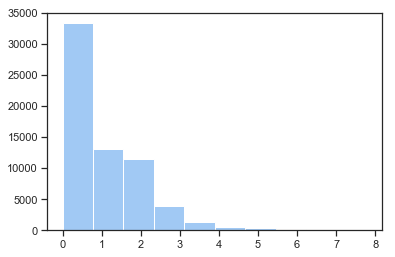

In [48]:
plt.hist(np.log(df_few_digit[df_few_digit["has_digit"] == 0]["likes_count"]+1))

(array([1.0647e+04, 5.2670e+03, 2.4380e+03, 1.0760e+03, 3.6400e+02,
        1.6000e+02, 8.7000e+01, 7.3000e+01, 3.4000e+01, 8.0000e+00]),
 array([0.        , 0.81842348, 1.63684695, 2.45527043, 3.27369391,
        4.09211739, 4.91054086, 5.72896434, 6.54738782, 7.3658113 ,
        8.18423477]),
 <a list of 10 Patch objects>)

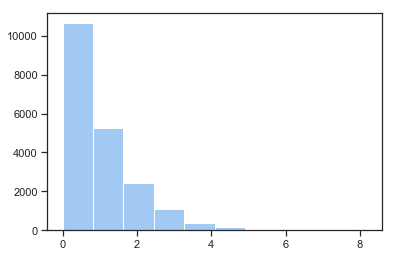

In [47]:
plt.hist(np.log(df_few_digit[df_few_digit["has_digit"] == 1]["likes_count"]+1))

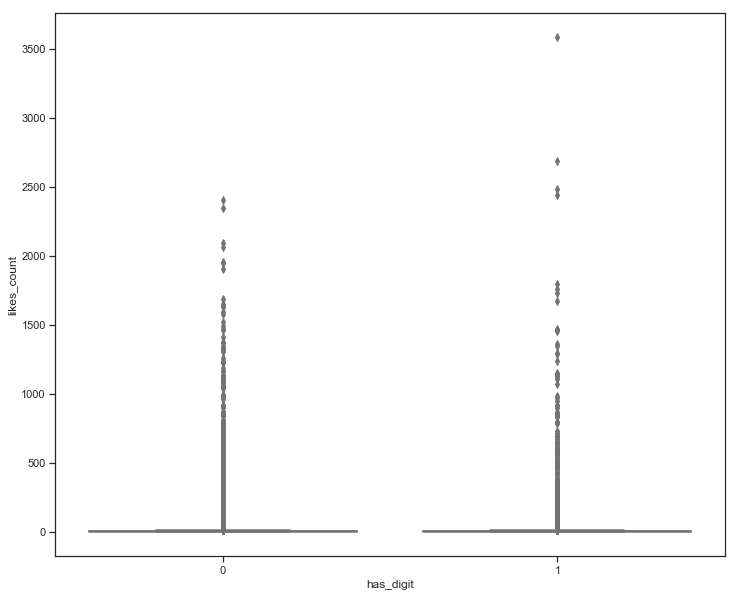

In [45]:
plt.figure(figsize=(12, 10))
sns.set(style="ticks", palette="pastel")
sns.boxplot(
    x="has_digit",
    y="likes_count",
#     hue="has_digit",
#     palette=["m", "g"],
    data=df_few_digit
)

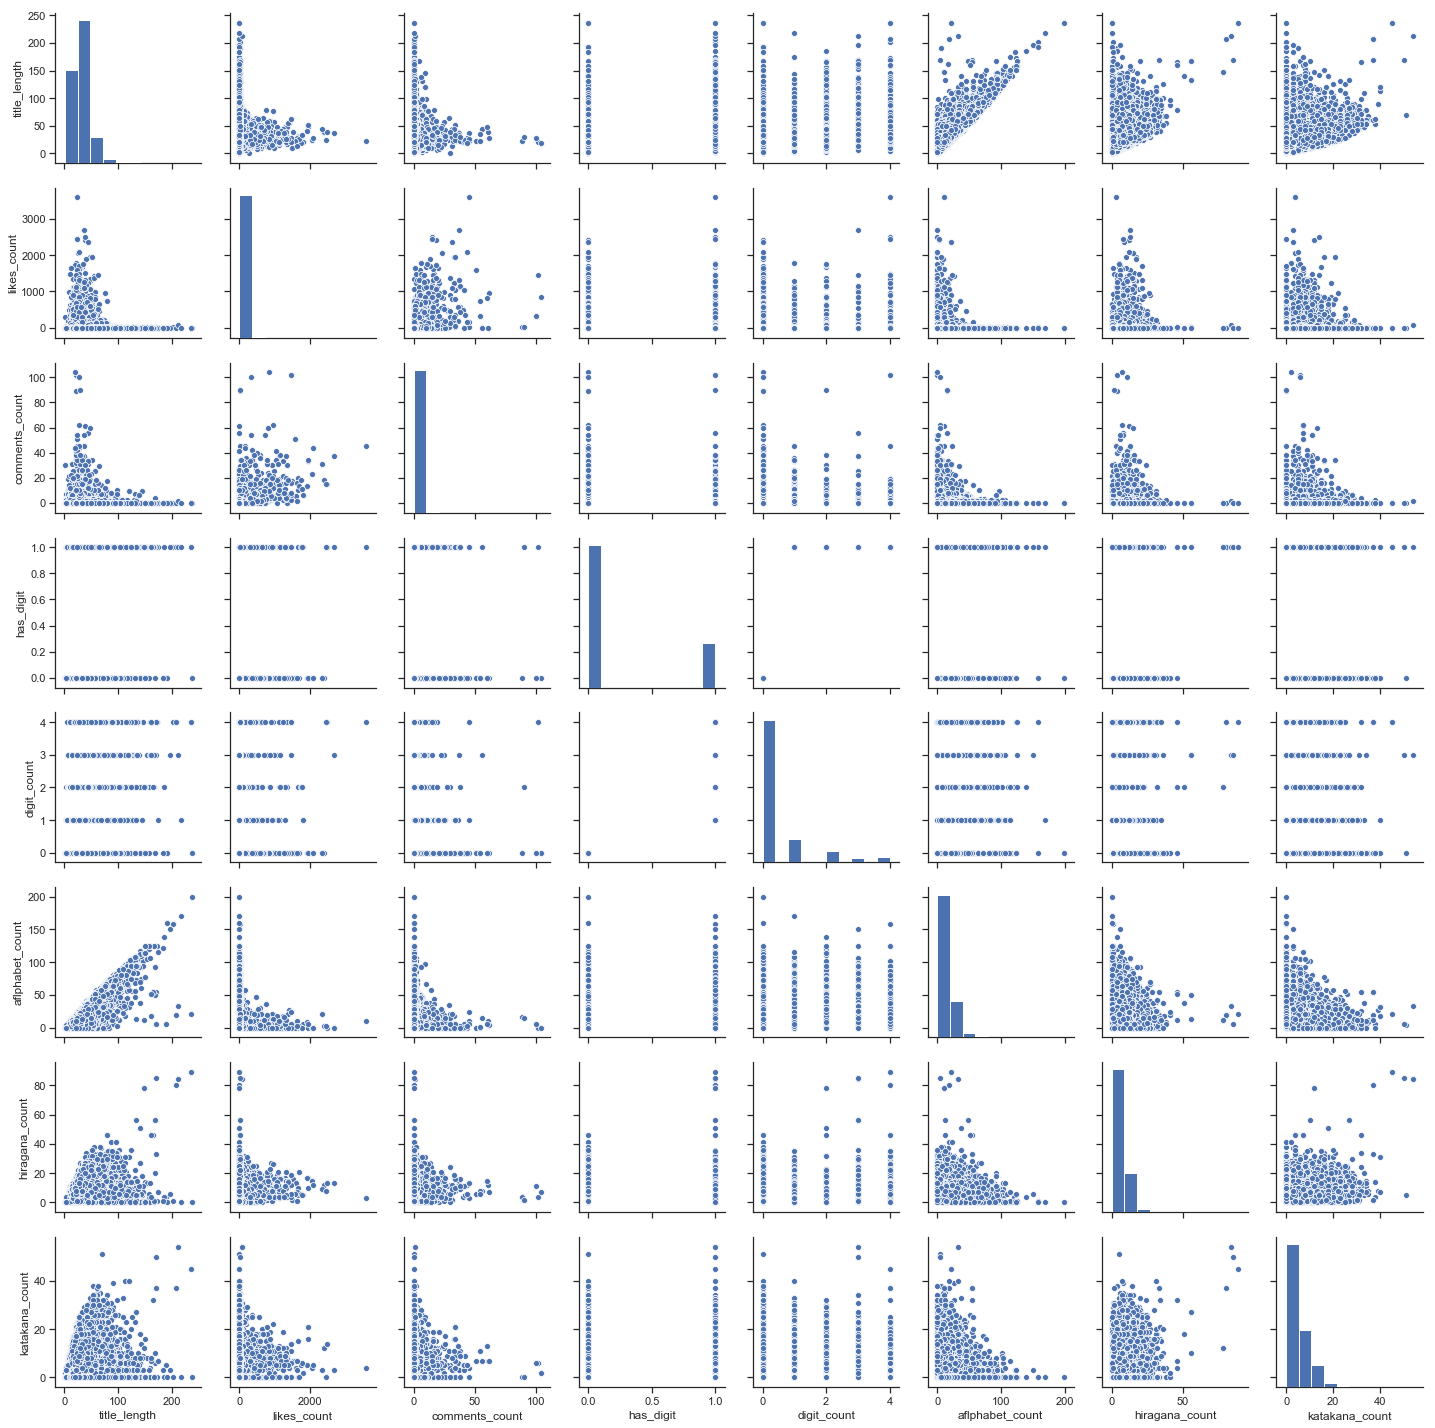

In [84]:
sns.pairplot(df_few_digit[[
    "title_length",    
    "likes_count",
    "comments_count",
    "has_digit",
    "digit_count",
    "aflphabet_count",
    "hiragana_count",
    "katakana_count",
]])

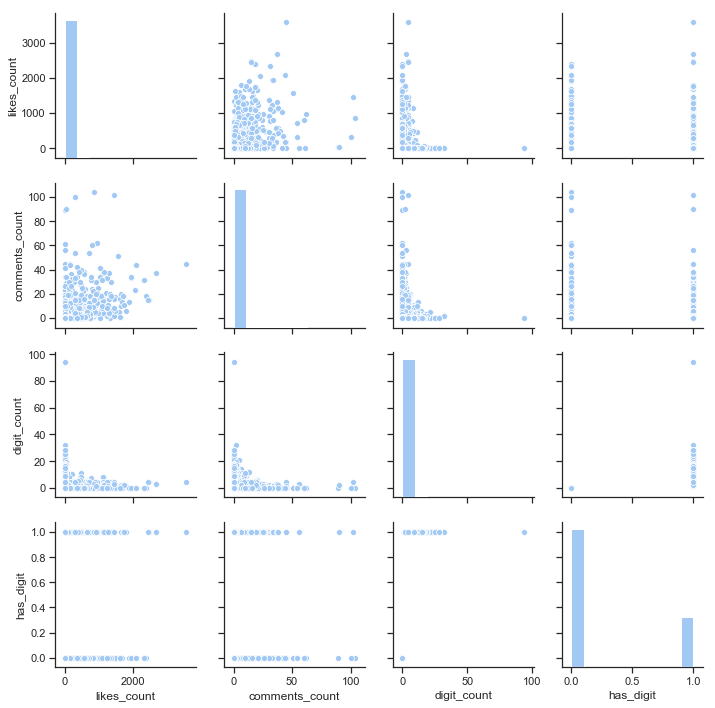

In [50]:
sns.pairplot(df[[
    "likes_count",
    "comments_count",
    "digit_count",
    "has_digit",
]])

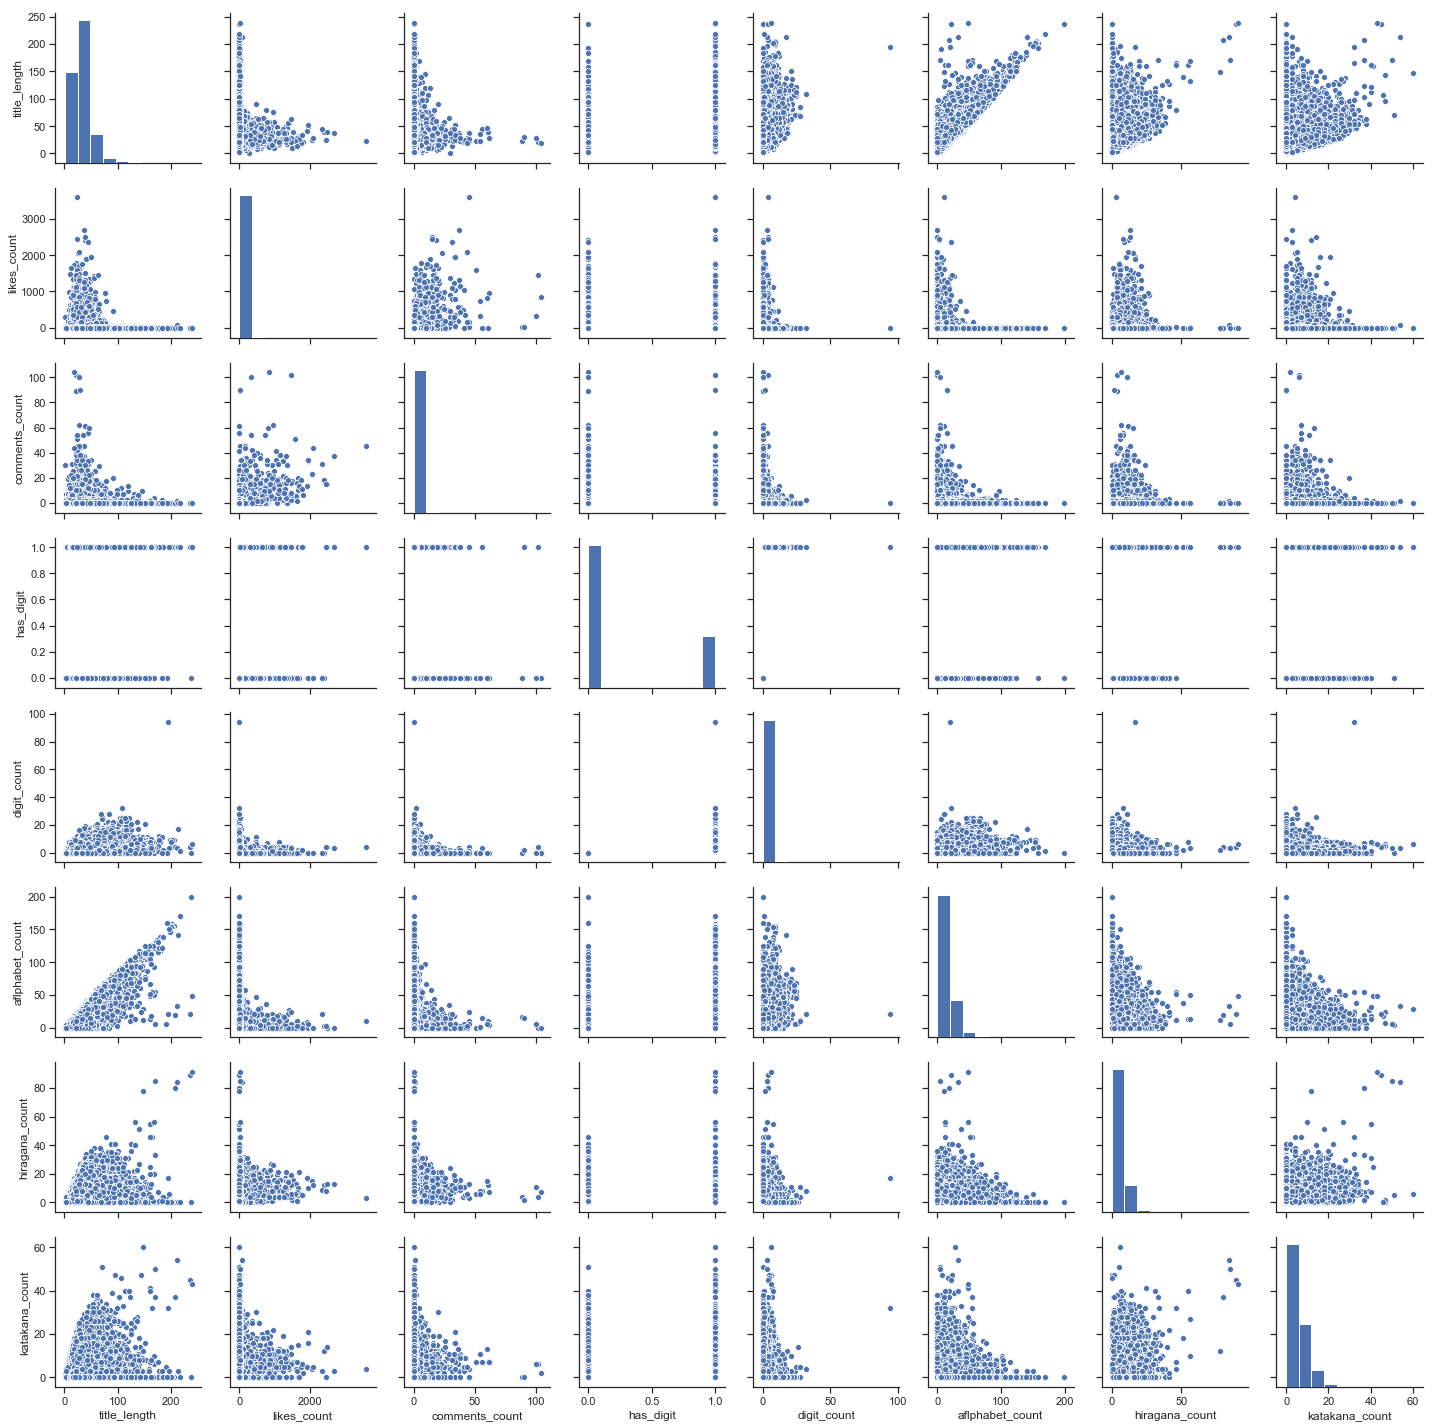

In [73]:
sns.pairplot(df[[
    "title_length",    
    "likes_count",
    "comments_count",
    "has_digit",
    "digit_count",
    "aflphabet_count",
    "hiragana_count",
    "katakana_count",
]])

# モデリング

In [82]:
with pm.Model() as model:
    b0 = pm.Normal("b0", mu=0, sd=100)
    b1 = pm.Normal("b1", mu=0, sd=100)
    
    has_digit = pm.HalfNormal("has_digit", sd=1, shape=len(df_few_digit["has_digit"].unique()))
    
    mu = b0 + b1 * has_digit[df_few_digit["has_digit"].values]
    obs = pm.Poisson("obs", mu=np.exp(mu), observed=df_few_digit["likes_count"].values)

In [83]:
with model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [has_digit, b1, b0]
Sampling 2 chains: 100%|██████████| 2000/2000 [44:20<00:00,  2.76s/draws]   
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9194345353105636, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [84]:
1+1

2

/Users/yuki/.pyenv/versions/miniconda3-4.1.11/envs/pymc3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


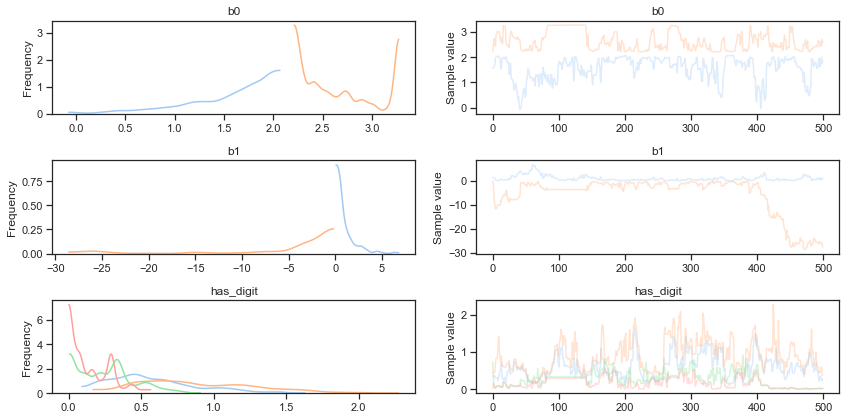

In [85]:
pm.traceplot(trace);

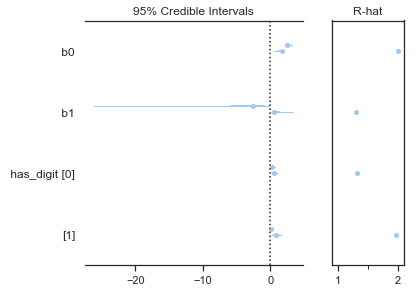

In [86]:
pm.forestplot(trace);

* 数字が含まれる記事は、含まれない記事よりも TODO
    * 一部のいいね数が多い記事のデータによって偏っているので一概には言えない

In [87]:
pm.summary(trace).sort_values(by='mean', ascending=False)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
b0,2.087644,0.677160,0.064199,0.864822,3.272508,1.386971,2.087206
has_digit__1,0.524685,0.476671,0.044696,0.000235,1.477699,1.474638,1.956367
has_digit__0,0.426984,0.298731,0.026824,0.005426,1.040816,3.584686,1.322026
b1,-2.399607,6.679685,0.662324,-25.676160,3.586481,3.402696,1.310382


とりあえず数字四桁（＝2018年などの年）を入れると良いことがわかる

In [62]:
df.describe()

,likes_count,comments_count,user_permanent_id,title_length,aflphabet_count,hiragana_count,katakana_count,digit_count,has_digit,other_count
count,87990.000000,87990.000000,87990.000000,87990.000000,87990.000000,87990.000000,87990.000000,87990.000000,87990.000000,87990.000000
mean,8.146949,0.319536,147978.537993,32.498113,14.049551,5.802944,4.558859,0.729378,0.266383,7.357382
std,58.144406,1.692475,88418.708976,16.596114,12.393118,4.441034,4.944165,1.909236,0.442069,5.253336
min,0.000000,0.000000,29.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,65978.000000,22.000000,6.000000,3.000000,0.000000,0.000000,0.000000,4.000000
50%,1.000000,0.000000,148882.000000,30.000000,11.000000,5.000000,4.000000,0.000000,0.000000,6.000000
75%,4.000000,0.000000,227518.000000,40.000000,19.000000,8.000000,7.000000,1.000000,1.000000,10.000000
max,3583.000000,104.000000,322336.000000,239.000000,199.000000,91.000000,60.000000,94.000000,1.000000,175.000000


In [59]:
df[df["has_digit"] == 1].describe()

,likes_count,comments_count,user_permanent_id,title_length,aflphabet_count,hiragana_count,katakana_count,digit_count,has_digit,other_count
count,23439.000000,23439.000000,23439.000000,23439.000000,23439.000000,23439.000000,23439.000000,23439.000000,23439.0,23439.000000
mean,8.543581,0.311276,144369.131021,38.660352,16.704936,5.416400,4.374291,2.738086,1.0,9.426639
std,67.918944,1.769156,90033.116293,20.411810,15.082275,4.695925,5.072019,2.860803,0.0,6.468192
min,0.000000,0.000000,29.000000,3.000000,0.000000,0.000000,0.000000,1.000000,1.0,0.000000
25%,0.000000,0.000000,55188.000000,26.000000,7.000000,2.000000,0.000000,1.000000,1.0,5.000000
50%,1.000000,0.000000,143947.000000,35.000000,13.000000,5.000000,3.000000,2.000000,1.0,8.000000
75%,3.000000,0.000000,227432.000000,46.000000,22.000000,8.000000,7.000000,3.000000,1.0,12.000000
max,3583.000000,102.000000,321957.000000,239.000000,170.000000,91.000000,60.000000,94.000000,1.0,130.000000


In [61]:
df[df["has_digit"] == 0].describe()

,likes_count,comments_count,user_permanent_id,title_length,aflphabet_count,hiragana_count,katakana_count,digit_count,has_digit,other_count
count,64551.000000,64551.000000,64551.000000,64551.000000,64551.000000,64551.000000,64551.000000,64551.0,64551.0,64551.000000
mean,8.002928,0.322536,149289.143406,30.260554,13.085359,5.943301,4.625877,0.0,0.0,6.606017
std,54.160249,1.663761,87789.147834,14.330611,11.102882,4.336301,4.895232,0.0,0.0,4.506452
min,0.000000,0.000000,29.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
25%,0.000000,0.000000,70276.000000,20.000000,6.000000,3.000000,0.000000,0.0,0.0,3.000000
50%,1.000000,0.000000,150494.000000,28.000000,11.000000,5.000000,4.000000,0.0,0.0,6.000000
75%,4.000000,0.000000,227518.000000,38.000000,18.000000,8.000000,7.000000,0.0,0.0,9.000000
max,2404.000000,104.000000,322336.000000,237.000000,199.000000,46.000000,51.000000,0.0,0.0,175.000000
